In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/data.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/data/train/present/UID_35_10_3_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_5_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_6_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_7_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_10_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_1_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_2_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_4_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_5_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_8_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_10_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_11_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_1_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_2_all.

In [4]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [5]:
train_path = "/content/data/data/train"
val_path = "/content/data/data/validation"
test_path = "/content/data/data/test"

In [6]:
IMAGE_SIZE = [224,224]

In [7]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255,
    rotation_range=30,           # Rotate images by up to 30 degrees
    width_shift_range=0.05,       # Translate horizontally by 20% of the width
    height_shift_range=0.05,      # Translate vertically by 20% of the height
    shear_range=0.1,             # Apply shear transformation
    zoom_range=0.1,              # Random zoom by up to 20%
    horizontal_flip=True,        # Flip images horizontally
    brightness_range=[0.8, 1.2],)
# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(224,224),
                                              batch_size=16,
                                              class_mode = 'categorical')

val_set = train_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            batch_size=16,
                                            class_mode='categorical')

Found 9616 images belonging to 2 classes.
Found 2062 images belonging to 2 classes.
Found 2060 images belonging to 2 classes.


In [9]:

from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [10]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [11]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# ResNet50

In [12]:
from tensorflow.keras.applications import ResNet50

resnet50=ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
x1= Flatten()(resnet50.output)
prediction1 = Dense(2, activation='softmax')(x1)
model4 = Model(inputs = resnet50.inputs, outputs = prediction1)
model4.summary()
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,788,418 (90.75 MB)

 Trainable params: 23,735,298 (90.54 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
hist4 = model4.fit(train_set, validation_data=test_set, epochs=30, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 238s 300ms/step - accuracy: 0.6855 - f1_m: 0.6855 - loss: 3.9600 - precision_m: 0.6855 - recall_m: 0.6855 - val_accuracy: 0.5000 - val_f1_m: 0.5005 - val_loss: 17.1262 - val_precision_m: 0.5005 - val_recall_m: 0.5005 - learning_rate: 0.0010
Epoch 2/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 224s 278ms/step - accuracy: 0.7657 - f1_m: 0.7657 - loss: 1.4025 - precision_m: 0.7657 - recall_m: 0.7657 - val_accuracy: 0.7442 - val_f1_m: 0.7445 - val_loss: 0.5428 - val_precision_m: 0.7445 - val_recall_m: 0.7445 - learning_rate: 0.0010
Epoch 3/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 202s 279ms/step - accuracy: 0.7528 - f1_m: 0.7528 - loss: 1.8669 - precision_m: 0.7528 - recall_m: 0.7528 - val_accuracy: 0.5010 - val_f1_m: 0.5015 - val_loss: 5.6406 - val_precision_m: 0.5015 - val_recall_m: 0.5015 - learning_rate: 0.0010
Epoch 4/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 204s 281ms/step - accuracy: 0.7885 - f1_m: 0.7885 - loss: 0.8654 - precision_m: 0.7885 - recall_m: 0.7885 - val_accurac

In [15]:
model4.save(f"/content/drive/MyDrive/{'Resnet50'}.h5")

In [16]:
scores = model4.evaluate(test_set)
storeResults("Resnet50", scores[1], scores[2], scores[3], scores[4])

129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9181 - f1_m: 0.9181 - loss: 0.2116 - precision_m: 0.9181 - recall_m: 0.9181


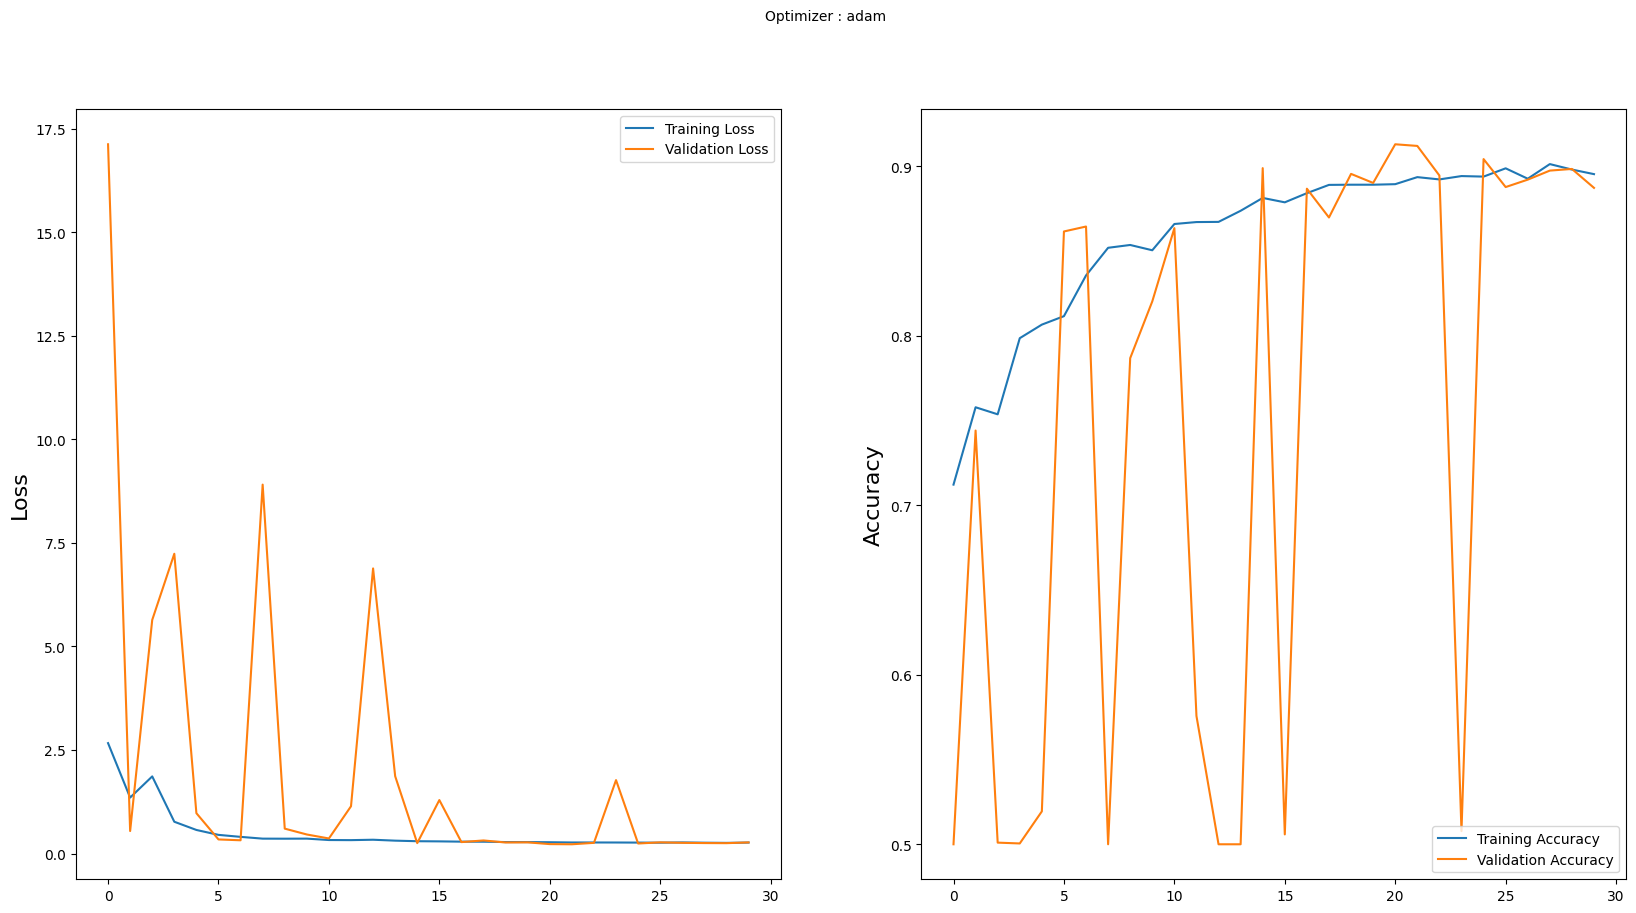

In [17]:
import matplotlib.pyplot as plt

x=hist4
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [18]:
import json

# Save training history to a JSON file
history_dict = hist4.history
with open(f"/content/drive/MyDrive/{'Resnet50'}_history.json", "w") as f:
    json.dump(history_dict, f)


In [19]:
print(hist4.history['accuracy'][-1])
print(hist4.history['precision_m'][-1])
print(hist4.history['recall_m'][-1])
print(hist4.history['f1_m'][-1])


0.8954867124557495
0.8954867124557495
0.8954867124557495
0.8954867124557495
